<a href="https://colab.research.google.com/github/SafaAhAwa/Projet-8-Participez-une-comp-tition-Kaggle-/blob/main/Notebook_Projet_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2S, EfficientNetV2M, EfficientNetV2B2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras import layers, models
import zipfile
import os
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
from tensorflow import keras
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from torch.utils.data import DataLoader, random_split
import plotly.graph_objects as go

In [85]:
train_df1 = pd.read_csv('train.csv')
train_df2 = pd.read_csv('training_extra.csv')
train_df = pd.concat([train_df1, train_df2], ignore_index=True)
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Analyse

In [6]:
train_df

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [8]:
(train_df.isnull().sum() / len(train_df)) * 100

id                      0.000000
Brand                   3.235000
Material                2.782333
Size                    2.198333
Compartments            0.000000
Laptop Compartment      2.481333
Waterproof              2.350000
Style                   2.656667
Color                   3.316667
Weight Capacity (kg)    0.046000
Price                   0.000000
dtype: float64

je constate que certaines colonnes (par exemple Brand, Color) ont environ 3 % de valeurs manquantes, ce qui n’est pas très élevé, mais reste suffisamment notable pour justifier une stratégie de traitement (imputation ou suppression). D’autres colonnes, comme Weight Capacity (kg), sont quasiment complètes (seulement ~0,05 % de valeurs manquantes), donc l’impact de la perte d’information sera minime. Dans l’ensemble, le pourcentage de valeurs manquantes n’est pas alarmant (il oscille généralement entre 2 et 3 % pour les colonnes concernées), et peut être traité relativement facilement (par exemple via l’imputation par la mode ou la médiane, en fonction du type de variable).

# Analyse des variables catégoriques

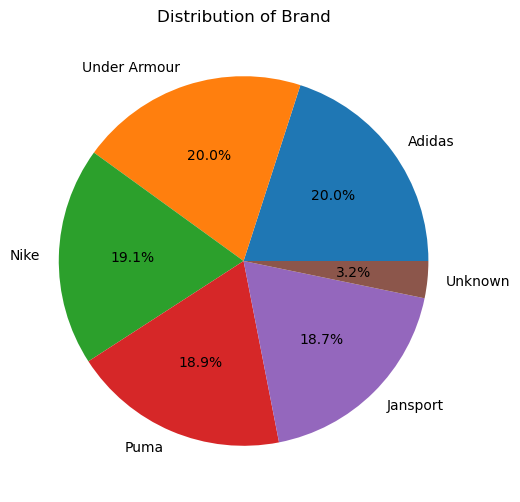

In [67]:
col = 'Brand'
# Compter les occurrences des catégories
counts = train_df[col].value_counts()

# Créer un camembert avec Matplotlib
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title(f"Distribution of {col}")
plt.show()

Je constate que la répartition des différentes marques est plutôt équilibrée : Under Armour occupe la plus grande part (environ 20,1 %), suivie de près par Adidas, Nike, Puma et Jansport avec des parts comprises entre 18 et 20 %. J’observe également qu’environ 3,17 % des valeurs sont nulles, ce qui reste un taux modéré à gérer.

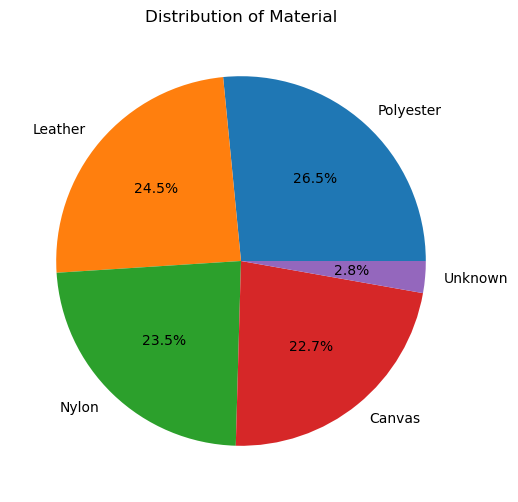

In [68]:
col = 'Material'
# Compter les occurrences des catégories
counts = train_df[col].value_counts()

# Créer un camembert avec Matplotlib
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title(f"Distribution of {col}")
plt.show()

On observe une répartition relativement équilibrée entre les différents matériaux, avec un léger avantage pour le polyester (environ 26,6 %). Le cuir, le nylon et la toile (canvas) se partagent ensuite des parts comparables (entre 22 et 24 %), tandis que près de 2,78 % des données sont nulles, un taux qui reste modeste et peut être géré.

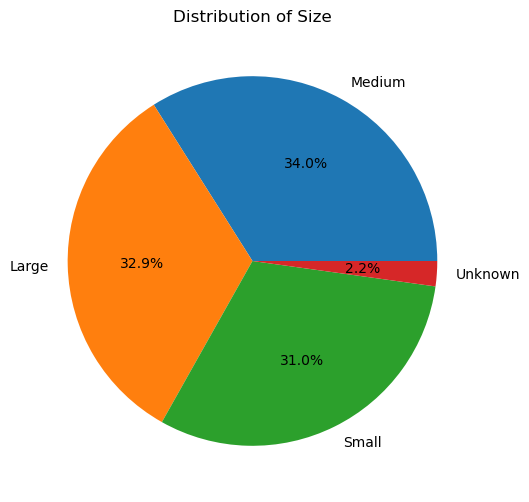

In [69]:
col = 'Size'
# Compter les occurrences des catégories
counts = train_df[col].value_counts()

# Créer un camembert avec Matplotlib
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title(f"Distribution of {col}")
plt.show()

Il n'y a que trois types de tailles : Medium, Large et Small, répartis de manière équilibrée, avec seulement 2,2 % de valeurs nulles.

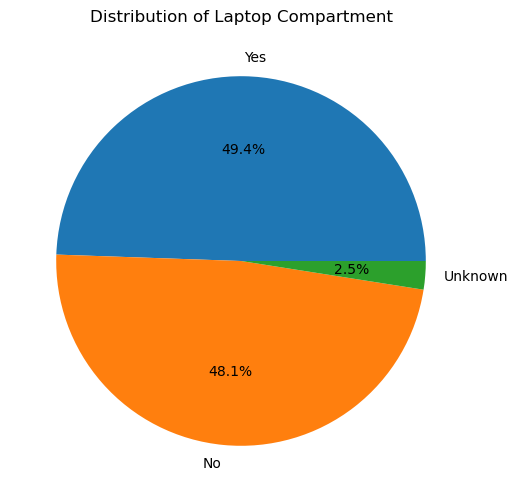

In [70]:
col = 'Laptop Compartment'
# Compter les occurrences des catégories
counts = train_df[col].value_counts()

# Créer un camembert avec Matplotlib
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title(f"Distribution of {col}")
plt.show()

On constate un équilibre presque parfait entre les sacs équipés d’un compartiment pour ordinateur (49,4 %) et ceux qui n’en ont pas (48,1 %). Les valeurs manquantes représentent environ 2,4 %, un taux relativement faible qui peut être facilement géré.

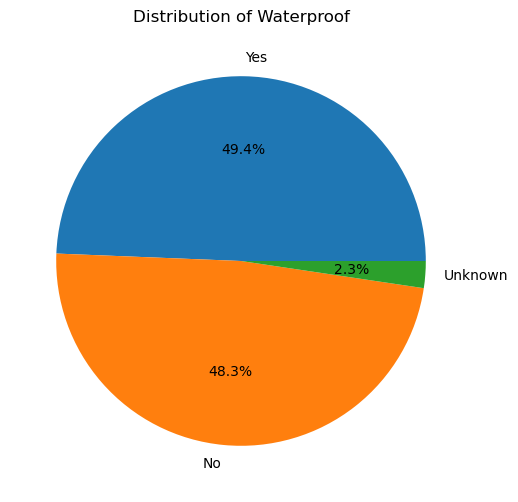

In [71]:
col = 'Waterproof'
# Compter les occurrences des catégories
counts = train_df[col].value_counts()

# Créer un camembert avec Matplotlib
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title(f"Distribution of {col}")
plt.show()

Le graphique montre une répartition quasi équilibrée entre "Yes" (49,3 %) et "No" (48,3 %), avec seulement 2,36 % de valeurs nulles. La faible proportion de valeurs manquantes limite leur impact sur l'analyse.

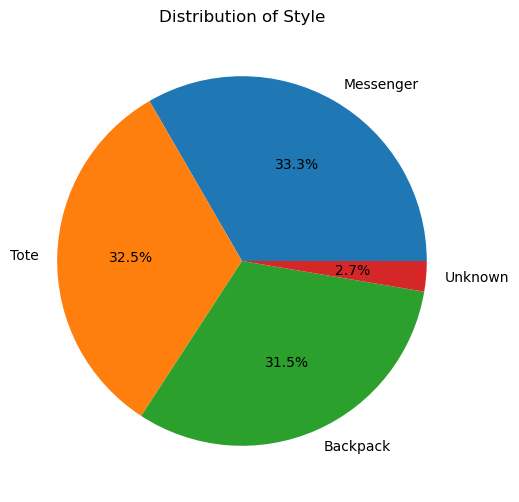

In [72]:
col = 'Style'
# Compter les occurrences des catégories
counts = train_df[col].value_counts()

# Créer un camembert avec Matplotlib
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title(f"Distribution of {col}")
plt.show()

Le graphique montre une répartition équilibrée entre les styles Messenger (33,3 %), Tote (32,5 %) et Backpack (31,6 %), avec seulement 2,61 % de valeurs nulles. La proportion de valeurs manquantes est faible et ne devrait pas impacter l’analyse de manière significative.

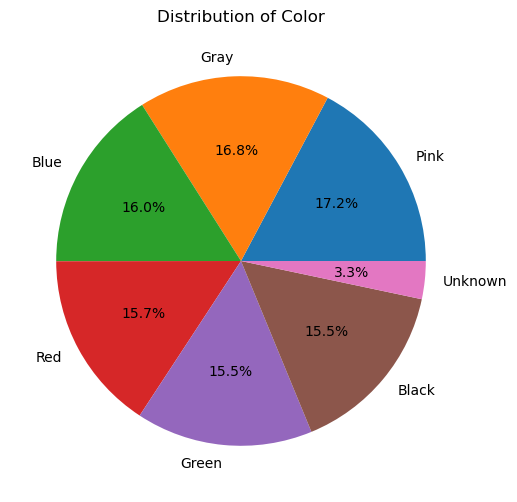

In [73]:
col = 'Color'
# Compter les occurrences des catégories
counts = train_df[col].value_counts()

# Créer un camembert avec Matplotlib
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title(f"Distribution of {col}")
plt.show()

Le graphique montre une répartition assez équilibrée des couleurs, avec des pourcentages variant entre 15,4 % et 17,2 % pour la majorité des couleurs. Seule la catégorie "null" représente une part plus faible (3,35 %), indiquant un faible taux de valeurs manquantes. Cette distribution suggère une bonne diversité des couleurs sans dominance marquée.

# Analyse des variables numériques

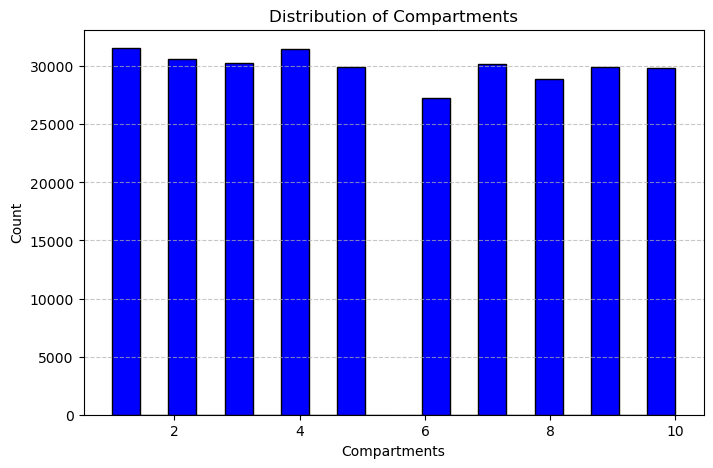

In [75]:
col = 'Compartments'
plt.figure(figsize=(8,5))  # Définir la taille du graphique
plt.hist(train_df[col], bins=20, color='blue', edgecolor='black')
plt.xlabel(col)
plt.ylabel("Count")
plt.title(f"Distribution of {col}")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajoute une grille pour la lisibilité
plt.show()

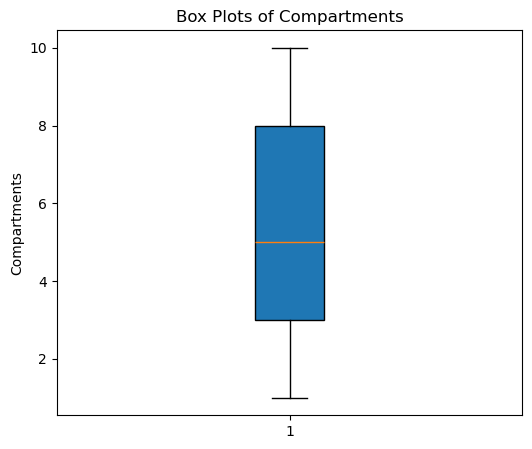

In [76]:
plt.figure(figsize=(6,5))
plt.boxplot(train_df[col], vert=True, patch_artist=True)
plt.ylabel(col)
plt.title(f"Box Plots of {col}")
plt.show()

Histogramme (Distribution de Compartments)

La distribution semble uniforme, avec une répartition relativement homogène des valeurs. Il n'y a pas de dominance claire d’une catégorie spécifique, ce qui indique une bonne diversité dans les données.

Boxplot (Box Plots of Compartments)

La médiane est centrée autour de 5. L’intervalle interquartile (IQR) couvre une large gamme de valeurs, allant environ de 2 à 8, montrant une bonne dispersion. Pas de valeurs extrêmes visibles, ce qui suggère l'absence d'outliers significatifs.

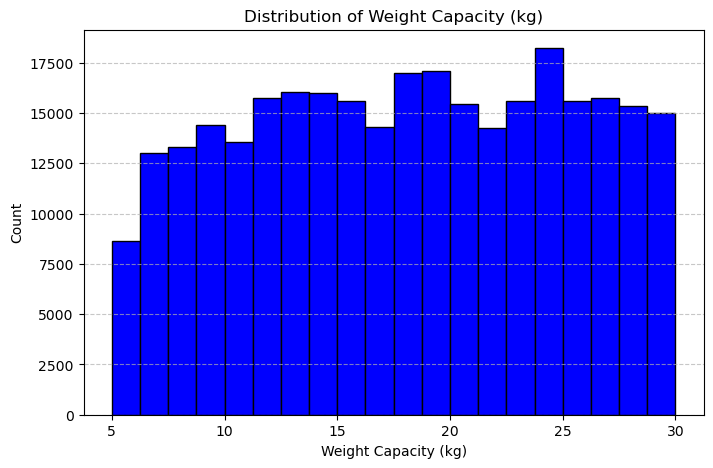

In [77]:
col = 'Weight Capacity (kg)'
plt.figure(figsize=(8,5))  # Définir la taille du graphique
plt.hist(train_df[col], bins=20, color='blue', edgecolor='black')
plt.xlabel(col)
plt.ylabel("Count")
plt.title(f"Distribution of {col}")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajoute une grille pour la lisibilité
plt.show()

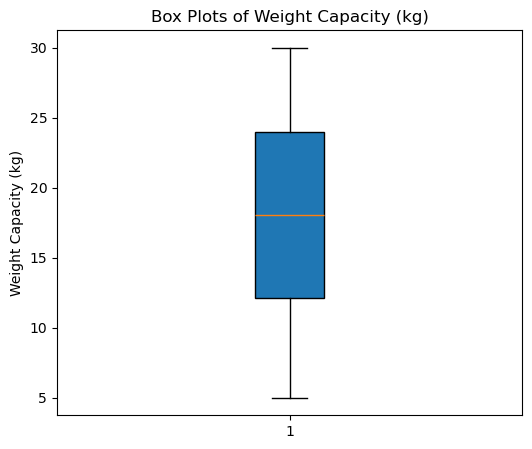

In [78]:
plt.figure(figsize=(6,5))
plt.boxplot(train_df[col], vert=True, patch_artist=True)
plt.ylabel(col)
plt.title(f"Box Plots of {col}")
plt.show()

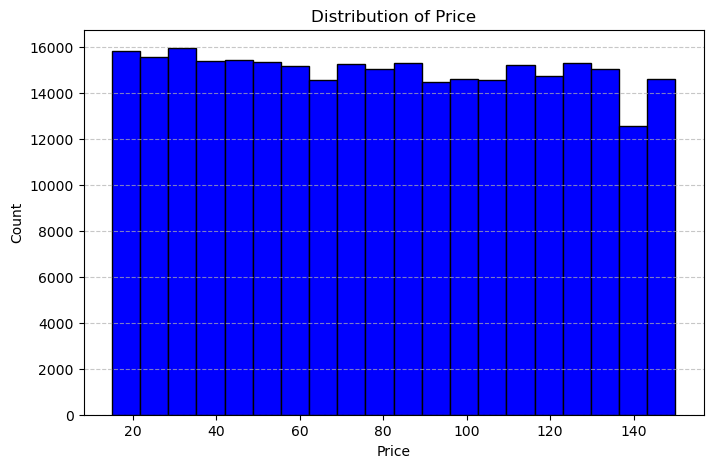

In [79]:
col = 'Price'
plt.figure(figsize=(8,5))  # Définir la taille du graphique
plt.hist(train_df[col], bins=20, color='blue', edgecolor='black')
plt.xlabel(col)
plt.ylabel("Count")
plt.title(f"Distribution of {col}")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajoute une grille pour la lisibilité
plt.show()

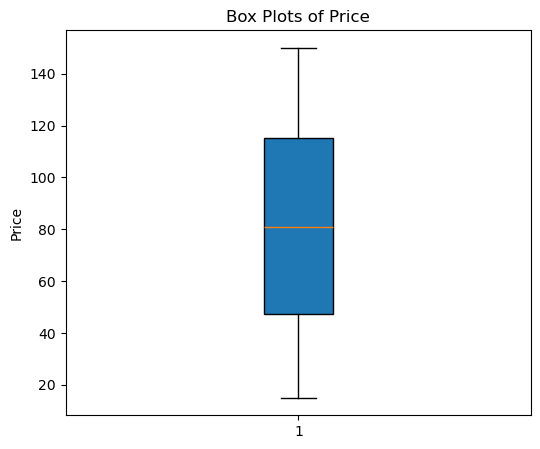

In [80]:
plt.figure(figsize=(6,5))
plt.boxplot(train_df[col], vert=True, patch_artist=True)
plt.ylabel(col)
plt.title(f"Box Plots of {col}")
plt.show()

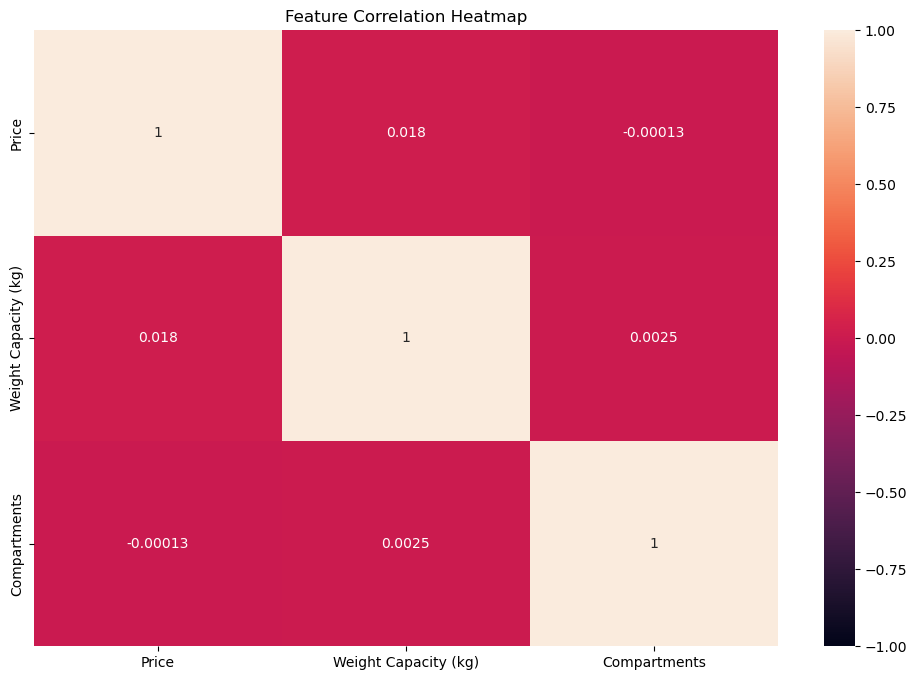

In [20]:
# Compute correlation matrix
corr_matrix = train_df[['Price', 'Weight Capacity (kg)', 'Compartments']].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

# Gestion des Valeurs Manquantes

In [21]:
for col in train_df.columns:
  if train_df[col].dtype == 'object':
    train_df.loc[:, col] = train_df[col].fillna("Unknown")

In [22]:
for col in train_df.columns:
  if train_df[col].dtype != 'object':
    train_df.loc[:, col] = train_df[col].fillna(np.mean(train_df[col]))

In [23]:
(train_df.isnull().sum() / len(train_df)) * 100

id                      0.0
Brand                   0.0
Material                0.0
Size                    0.0
Compartments            0.0
Laptop Compartment      0.0
Waterproof              0.0
Style                   0.0
Color                   0.0
Weight Capacity (kg)    0.0
Price                   0.0
dtype: float64

# One-Hot Encoding

In [24]:
# Select categorical columns (object dtype)
cat_cols = train_df.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding
train_df1 = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

# Train-test split

In [25]:
# Train-test split
from sklearn.model_selection import train_test_split
X = train_df1.drop(columns=['Price', 'id'])  # Features
y = train_df1['Price']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LinearRegression

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))


print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", rmse)

Linear Regression MAE: 33.64123645874511
Linear Regression RMSE: 38.91338090391271


MAE = 33.64 → En moyenne, l'erreur absolue sur le prix prédit est de 33.64 unités.
RMSE = 38.91 → Comme RMSE pénalise plus fortement les grandes erreurs, cela montre que certaines prédictions peuvent être significativement fausses.
MAE < RMSE → Cela indique la présence de quelques valeurs extrêmes (outliers) qui impactent les erreurs.
RMSE (38.91) est très proche du meilleur score (38.81). https://www.kaggle.com/competitions/playground-series-s5e2/leaderboard

# xgboost

In [28]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("xgboost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("xgboost RMSE:", rmse)

xgboost MAE: 33.638080921705004
xgboost RMSE: 38.9332258872273


e modèle XGBoost donne une MAE de 33.63 et une RMSE de 38.93, ce qui est très proche des résultats de la régression linéaire. Cela suggère que, malgré la puissance de XGBoost, le modèle ne parvient pas à capturer beaucoup plus d’informations que la simple régression linéaire, indiquant peut-être un manque de features discriminantes ou la nécessité d’un meilleur prétraitement des données.

## Optimize XGBoost Hyperparameters

In [48]:
xgb_model = xgb.XGBRegressor(
    n_estimators=800,  # Augmente le nombre d'arbres
    learning_rate=0.01,  # Apprentissage plus progressif
    max_depth=4,  # Profondeur des arbres
    subsample=0.5,  # Échantillonnage pour éviter le surajustement
    colsample_bytree=0.7,  # Sélection de colonnes aléatoires
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("xgboost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("xgboost RMSE:", rmse)

xgboost MAE: 33.62349649586886
xgboost RMSE: 38.90070721236962


Modifier les paramètres de XGBoost a permis d'améliorer légèrement le résultat, passant de 38.93 à 38.90.

# Lightgbm

In [ ]:
pip install lightgbm

In [52]:
import lightgbm as lgb

# Define the model
# Remove device="gpu" to use CPU for training
lgb_model = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

# Compute RMSE
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print("LightGBM MAE:", mean_absolute_error(y_test, y_pred_lgb))
print("LightGBM RMSE:", rmse_lgb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 27
[LightGBM] [Info] Start training from score 81.448481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

# Create Submission

## Fill empty row

In [53]:
for col in test_df.columns:
  if test_df[col].dtype == 'object':
    test_df.loc[:, col] = test_df[col].fillna("Unknown")

In [54]:
for col in test_df.columns:
  if test_df[col].dtype != 'object':
    test_df.loc[:, col] = test_df[col].fillna(np.mean(test_df[col]))

## One-Hot Encoding

In [55]:
# Select categorical columns (object dtype)
cat_cols = test_df.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding
test_df = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)

In [58]:
test_df_preprocessed = test_df[X_train.columns]

In [59]:
test_df = test_df_preprocessed

In [60]:
y_pred_test = xgb_model.predict(test_df)

# Add predictions to the test DataFrame
test_df['Predicted Price'] = y_pred_test

In [61]:
test_df

,Compartments,Weight Capacity (kg),Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Brand_Unknown,Material_Leather,Material_Nylon,Material_Polyester,...,Style_Messenger,Style_Tote,Style_Unknown,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Color_Unknown,Predicted Price
0,2.0,20.671147,False,False,True,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,82.029900
1,7.0,13.564105,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,82.458931
2,9.0,11.809799,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,82.412971
3,1.0,18.477036,False,False,False,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,81.837029
4,2.0,9.907953,False,False,False,False,True,False,True,False,...,False,True,False,False,False,False,False,False,False,79.201263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2.0,7.383498,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,79.621552
199996,9.0,6.058394,False,True,False,False,False,False,False,True,...,True,False,False,False,False,False,True,False,False,78.743515
199997,9.0,26.890163,True,False,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,83.483803
199998,10.0,25.769153,False,False,True,False,False,False,True,False,...,False,True,False,False,True,False,False,False,False,81.594276


In [63]:
submission = test_df[['Predicted Price']]

In [64]:
submission = submission.rename(columns={'Predicted Price': 'Price'})